## Homework 4: due 2022/05/09 23:59 (100%)

### - Tutorial : 

1. Training on MNIST: https://www.kaggle.com/code/juiyangchang/cnn-with-pytorch-0-995-accuracy
2. Torchvision transforms: https://pytorch.org/vision/stable/transforms.html
3. Pytorch learning rate scheduler: https://pytorch.org/docs/stable/optim.html
4. How to get learning rate: https://stackoverflow.com/questions/52660985/pytorch-how-to-get-learning-rate-during-training

### - After you go through the tutorials, you should be able to work on this assignment.

### - Please answer the following questions and work directly on this jupyter notebook.

### - Make sure the code can be run and show the result and figures properly.

### - Please write down your observation with markdown in this notebook briefly.



#### You will train a multi-class classfication model in this part. The data contains the images with three categories: cats, dogs and pandas. You can find the details of each column at https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda.

In [12]:
# Import necessory modules
%matplotlib inline
import os
import glob
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as tr
import torchvision.models as models
from torch.optim.lr_scheduler import MultiStepLR
import PIL.Image as Image
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [13]:
# For reproduce the result
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### 1. Define the model and dataset (30%)

#### 1.1 Please create a class **AnimalDataset** for loading the data, and a varibale ***transform*** for the preprocessing transformation should be created for later usage.  (15%)

In [14]:
class AnimalDataset():
    def __init__(self , path,transform=None):
        self.path = path
        self.category = os.listdir(self.path)
        self.categorys ={i: cls for i , cls in enumerate(self.category)}
        self.data =[]
        self.transform = transform
        for cls in os.listdir(self.path):
            for img in glob.glob(os.path.join(self.path, cls, "*.jpg")):
                self.data.append([img,self.category.index(cls)])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img = Image.open(self.data[index][0]).convert('RGB')
        if self.transform!=None:
            x = self.transform(img)
        y = self.data[index][1]
        return x, y, self.data[index][0]

#### 1.2 Please create a class **CNN** as your network with the architecture below. (15%)
##### (Note. Please determine the output layer by the task)

| Block 1 | Block 2 |  Fully Connected Layer |
|:---:|:---:|:---:|
| 3x3 conv, 64 | 3x3 conv, 128 |  Linear, 512 |
| ReLU         | ReLU   |Dropout(p=0.5)  |
| 2x2 MaxPooling, downsampling factor 2       | 2x2 MaxPooling, downsampling factor 2   | ReLU  |
|          |    |Linear, 256  |
|          |    |Dropout(p=0.5)  |
|          |    |ReLU |

In [15]:
class CNN(nn.Module):
    def __init__(self, classes):
        super(CNN, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels= 64,kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fullyconnected = nn.Sequential(
            nn.Linear(128*8*8,512),   #32*32 MaxPool 2*2 2times got 8*8
            nn.Dropout(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(512,256),
            nn.Dropout(p=0.5),
            nn.ReLU(inplace=True)
        )
        self.output_layer = nn.Linear(256, classes) #find 256 but only need 3 (dog cat panda)
    def forward(self, X):
        X = self.block1(X)
        X = self.block2(X)
        X = torch.flatten(X,1)
        X = self.fullyconnected(X)
        X = self.output_layer(X)
        return X
               

### 2. Train the model (70%)

#### 2.1 Please load the train/validation/test data from ***./animals*** respectively and resize the image to 32x32. For the data preprocessing, please apply ***RandomHorizontalFlip(p=0.5)*** and ***RandomRotation((-10,10))*** as data augmentations. Also, scale all the value in the range between 0 and 1 and normalize with mean value ***(0.485,0.456,0.406)*** and standard deviation ***(0.229,0.224,0.225)*** for RGB channel respectively. At last, create the DataLoaders with batch size 32.(10%)
##### (Note. The mean and standard deviation is calculated from ImageNet dataset) 

In [16]:
def data_transforms(phase = None):
    if phase == 'TRAIN':
        transforms = tr.Compose([
        tr.Resize((32,32)),
        tr.RandomHorizontalFlip(p=0.5),
        tr.RandomRotation((-10, 10)),
        tr.ToTensor(),
        tr.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
    ])
    elif phase == 'TEST' or phase == 'VAL':
        transforms = tr.Compose([
        tr.Resize((32,32)),
        tr.ToTensor(),
        tr.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
    ])
    return transforms
train_dataset = AnimalDataset("./animals/train", data_transforms('TRAIN'))
val_dataset = AnimalDataset("./animals/val", data_transforms('VAL'))
test_dataset = AnimalDataset("./animals/test", data_transforms('TEST'))

train_dataloader = DataLoader(train_dataset, batch_size=32,shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32,shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32,shuffle=False)


In [17]:
def imshow(img, size=(20, 20)):
    img = img / 2 + 0.5
    npimg = img.numpy()
    if size:
        plt.figure(figsize=size)
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("One mini batch")
    plt.axis("off")
    plt.pause(0.001)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


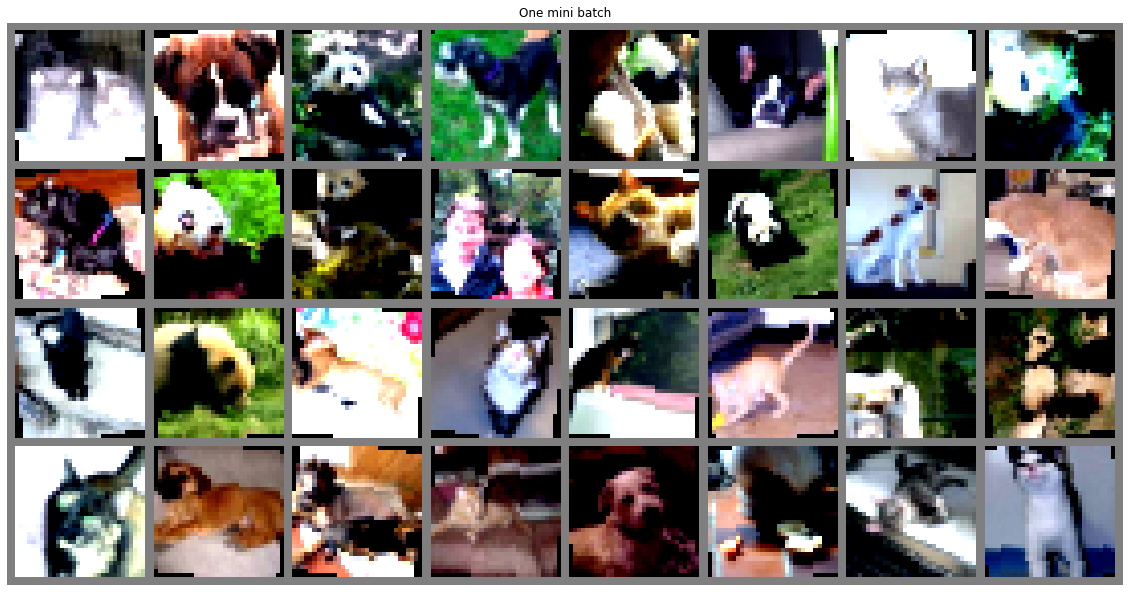

In [18]:
import torchvision
dataiter = iter(train_dataloader)
images, labels ,_= dataiter.next()

imshow(torchvision.utils.make_grid(images))

#### 2.2 Train the CNN model with the same hyperpameters below and do the validation every epoch. Choose the appropriate type of loss according to the task. Please record the learning rate, training/validation loss and training/validation accuracy every epoch. Also, save the model weights as ***model_without_scheduler.pth***(20%)


| | Learning rate | epochs | optimizer | weight decay | $\beta _1$|$\beta _2$|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|***Hyperparameter***| 5e-3 | 100 | Adam | 1e-2 | 0.9 | 0.99 |

In [19]:
def accuracy_fn(y_pred,y_true):
    y_pred = torch.exp(y_pred)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [20]:
classes =3
model = CNN(classes)
learning_rate = 0.005
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2, betas=(0.9, 0.99))


In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
model = model.to(device)
epoch =100
result = {"Training Loss":[], "Validation Loss":[], "Training Accuracy":[], "Validation Accuracy":[]}



The model will be running on cuda:0 device


In [23]:
pbar_epoch = tqdm(range(epoch))
lr = []
for i in pbar_epoch:
    train_losses = []
    train_accuracy =[]
    validation_losses = []
    validation_accuracy = []
    # train_cf = np.zeros((classes, classes))
    # val_cf = np.zeros(((classes, classes)))
    
    model.train()
    for inputs, label,_ in train_dataloader:
        inputs = inputs.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = loss_fn(outputs, label)
        train_losses.append(loss)
        accuracy = accuracy_fn(outputs,label)
        train_accuracy.append(accuracy)
        
        loss.backward()
        optimizer.step()
        loss = loss.detach().cpu().numpy()
        accuracy = accuracy.detach().cpu().numpy()
    average_train_loss = torch.stack(train_losses).mean().item()
    average_train_accuracy = torch.stack(train_accuracy).mean().item()
    result["Training Loss"].append(average_train_loss)  
    result["Training Accuracy"].append(average_train_accuracy)  
    model.eval()
    for inputs, label, _ in val_dataloader:
        with torch.no_grad():
            
            inputs = inputs.to(device)
            label = label.to(device)
            outputs = model(inputs)
            
            loss = loss_fn(outputs, label)
            validation_losses.append(loss)
            accuracy = accuracy_fn(outputs,label)
            validation_accuracy.append(accuracy)
            
            loss = loss.cpu().numpy()
            accuracy = accuracy.detach().cpu().numpy()
    average_val_loss= torch.stack(validation_losses).mean().item()
    average_val_accuracy = torch.stack(validation_accuracy).mean().item()
    result["Validation Loss"].append(average_val_loss)    
    result["Validation Accuracy"].append(average_val_accuracy)
    lr.append(optimizer.param_groups[0]['lr'])

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
path = "./model_without_scheduler.pth"
torch.save(model.state_dict(), path)

#### 2.3 Please draw the plot the learning rate, training/validation loss and training/validation accuracy and write down the observation. (10%)
##### (Example figure)
![image.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW4/img/curve1.png?raw=true)

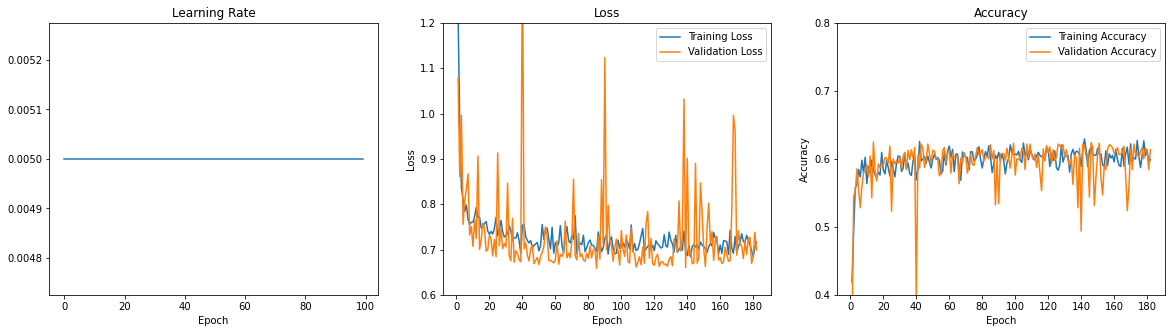

In [25]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
ax[0].plot()
ax[0].plot(range(len(lr)), lr)
ax[0].set_xticks(np.arange(0, len(lr)+1, 20))
ax[0].set_title("Learning Rate")
ax[0].set_xlabel("Epoch")
metrics = ["Loss", "Accuracy"]
yaxis = [([0.6,1.2], (np.arange(0.6, 2, 0.1))), ([0.4,0.8],(np.arange(0.4, 1  , 0.1)))]
for i, (yt, met) in enumerate(zip(yaxis, metrics)):
    ax[i+1].set_title(met)
    ax[i+1].set_xlabel("Epoch")
    ax[i+1].set_ylabel(met)
    ax[i+1].set_xticks(np.arange(0, len(result[f"Training {met}"])+1, 20))
    ax[i+1].set_yticks(yt[1])
    ax[i+1].set_ylim(yt[0])
    ax[i+1].plot(np.arange(1, len(result[f"Training {met}"])+1), result[f"Training {met}"], label=f"Training {met}")
    ax[i+1].plot(np.arange(1, len(result[f"Validation {met}"])+1),  result[f"Validation {met}"], label=f"Validation {met}")
    ax[i+1].legend()
plt.show()

#### 2.4 Please retrain model with learning rate decay with decreasing factor 0.1 at 20 epoch and 60 epoch. The other parameters are as same as last question. Also, redraw the learning rate, accuracy and loss curves and save the weights as ***model_with_scheduler.pth***. (10%)
##### (Example figure)
![image.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW4/img/curve2.png?raw=true)

In [26]:
classes =3
model = CNN(classes)
learning_rate = 0.005
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2, betas=(0.9, 0.99))
scheduler = MultiStepLR(optimizer, milestones=[20, 60], gamma=0.1)

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
model = model.to(device)
epoch =100
result = {"Training Loss":[], "Validation Loss":[], "Training Accuracy":[], "Validation Accuracy":[]}


The model will be running on cuda:0 device


In [28]:
pbar_epoch = tqdm(range(epoch))
lr = []
for i in pbar_epoch:
    train_losses = []
    train_accuracy =[]
    validation_losses = []
    validation_accuracy = []
    
    
    for inputs, label,_ in train_dataloader:
        model.train()
        inputs = inputs.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = loss_fn(outputs, label)
        train_losses.append(loss)
        accuracy = accuracy_fn(outputs,label)
        
        train_accuracy.append(accuracy)
        loss.backward()
        optimizer.step()
        loss = loss.detach().cpu().numpy()
        accuracy = accuracy.detach().cpu().numpy()
        
        
        
        
        
    average_train_loss = torch.stack(train_losses).mean().item()
    average_train_accuracy = torch.stack(train_accuracy).mean().item()
    result["Training Loss"].append(average_train_loss)  
    result["Training Accuracy"].append(average_train_accuracy)  
    
    for inputs, label, _ in val_dataloader:
        with torch.no_grad():
            model.eval()
            inputs = inputs.to(device)
            label = label.to(device)
            outputs = model(inputs)
            
            loss = loss_fn(outputs, label)
            validation_losses.append(loss)
            accuracy = accuracy_fn(outputs,label)
            validation_accuracy.append(accuracy)
            
            loss = loss.cpu().numpy()
            accuracy = accuracy.detach().cpu().numpy()
    average_val_loss= torch.stack(validation_losses).mean().item()
    average_val_accuracy = torch.stack(validation_accuracy).mean().item()
    result["Validation Loss"].append(average_val_loss)    
    result["Validation Accuracy"].append(average_val_accuracy)
    scheduler.step() 
    lr.append(optimizer.param_groups[0]['lr'])

  0%|          | 0/100 [00:00<?, ?it/s]

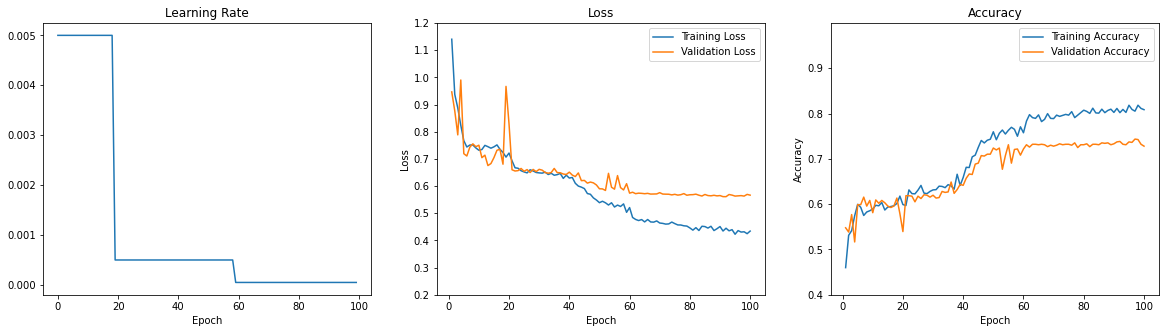

In [29]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
ax[0].plot()
ax[0].plot(range(len(lr)), lr)
ax[0].set_xticks(np.arange(0, len(lr)+1, 20))
ax[0].set_title("Learning Rate")
ax[0].set_xlabel("Epoch")
metrics = ["Loss", "Accuracy"]
yaxis = [([0.2,1.2], (np.arange(0.2, 2, 0.1))), ([0.4,1],(np.arange(0.4, 1  , 0.1)))]
for i, (yt, met) in enumerate(zip(yaxis, metrics)):
    ax[i+1].set_title(met)
    ax[i+1].set_xlabel("Epoch")
    ax[i+1].set_ylabel(met)
    ax[i+1].set_xticks(np.arange(0, len(result[f"Training {met}"])+1, 20))
    ax[i+1].set_yticks(yt[1])
    ax[i+1].set_ylim(yt[0])
    ax[i+1].plot(np.arange(1, len(result[f"Training {met}"])+1), result[f"Training {met}"], label=f"Training {met}")
    ax[i+1].plot(np.arange(1, len(result[f"Validation {met}"])+1),  result[f"Validation {met}"], label=f"Validation {met}")
    ax[i+1].legend()
plt.show()

In [30]:
path = "./model_with_scheduler.pth"
torch.save(model.state_dict(), path)

#### 2.5 Please calculate the confusion matrix and print the accuracy of two models with the test dataset. (10%)
##### (Example figure)
![image.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW4/img/confusion%20matrix.png?raw=true)

In [35]:
from sklearn.metrics import confusion_matrix
model1 = CNN(classes = 3)
model1.load_state_dict(torch.load("model_without_scheduler.pth"))
model1 = model1.to(device)
model2 = CNN(classes = 3)
model2.load_state_dict(torch.load("model_with_scheduler.pth"))
model2 = model2.to(device)
model1_pred=[]
model2_pred=[]
label_list = []
for inputs, label, _ in tqdm(test_dataloader):
    with torch.no_grad():
        model.eval()
        inputs = inputs.to(device)
        label = label.to(device)
        outputs1 = model1(inputs)
        outputs2 = model2(inputs)
        _,pred1 = torch.max(outputs1,1)
        _,pred2 = torch.max(outputs2,1)
        model1_pred.extend(pred1.view(-1).detach().cpu().numpy())
        model2_pred.extend(pred2.view(-1).detach().cpu().numpy())
        label_list.extend(label.view(-1).detach().cpu().numpy())


  0%|          | 0/7 [00:00<?, ?it/s]

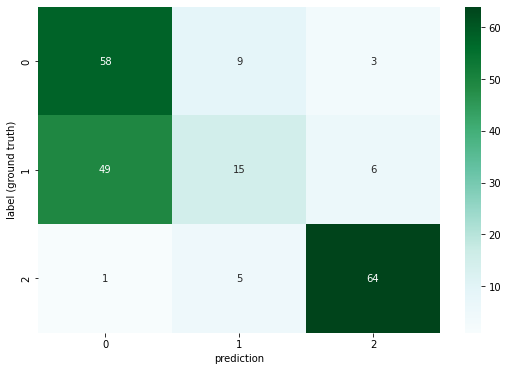

In [41]:
import seaborn as sns
class_names = ['0', '1', '2']
cf_matrix1 = confusion_matrix(label_list, model1_pred)
df_cm = pd.DataFrame(cf_matrix1, class_names, class_names)  
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()


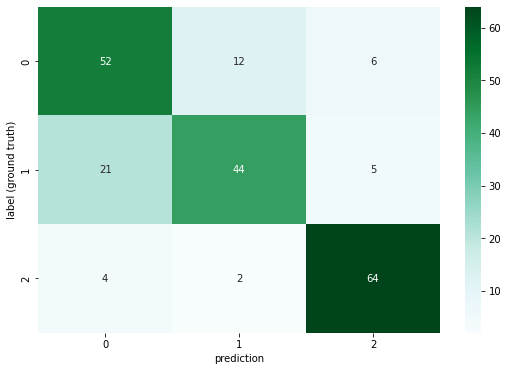

In [42]:
cf_matrix2 = confusion_matrix(label_list, model2_pred)
df_cm = pd.DataFrame(cf_matrix2, class_names, class_names)  
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

#### 2.6 Please choose the best model to predict the categories of images in the ***./animals/predict*** folder and show the figure with the prediction as title of each axes. (10%)
##### (Example figure)
![image.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW4/img/img1.png?raw=true)

In [32]:
pred_list = glob.glob(os.path.join("./animals/prediction", "*.jpg"))

In [33]:
model = CNN( classes = 3)
model.load_state_dict(torch.load("model_with_scheduler.pth"))
prediction = []
img_list = []
for img_pth in pred_list:
    img = Image.open(img_pth)
    img_list.append(img)
    inputs = train_dataset.transform(img)
    inputs = torch.unsqueeze(inputs, 0)
    with torch.no_grad():
        model.eval()
        logits = model(inputs)
        pred = int(torch.argmax(logits, 1))
        prediction.append(pred)

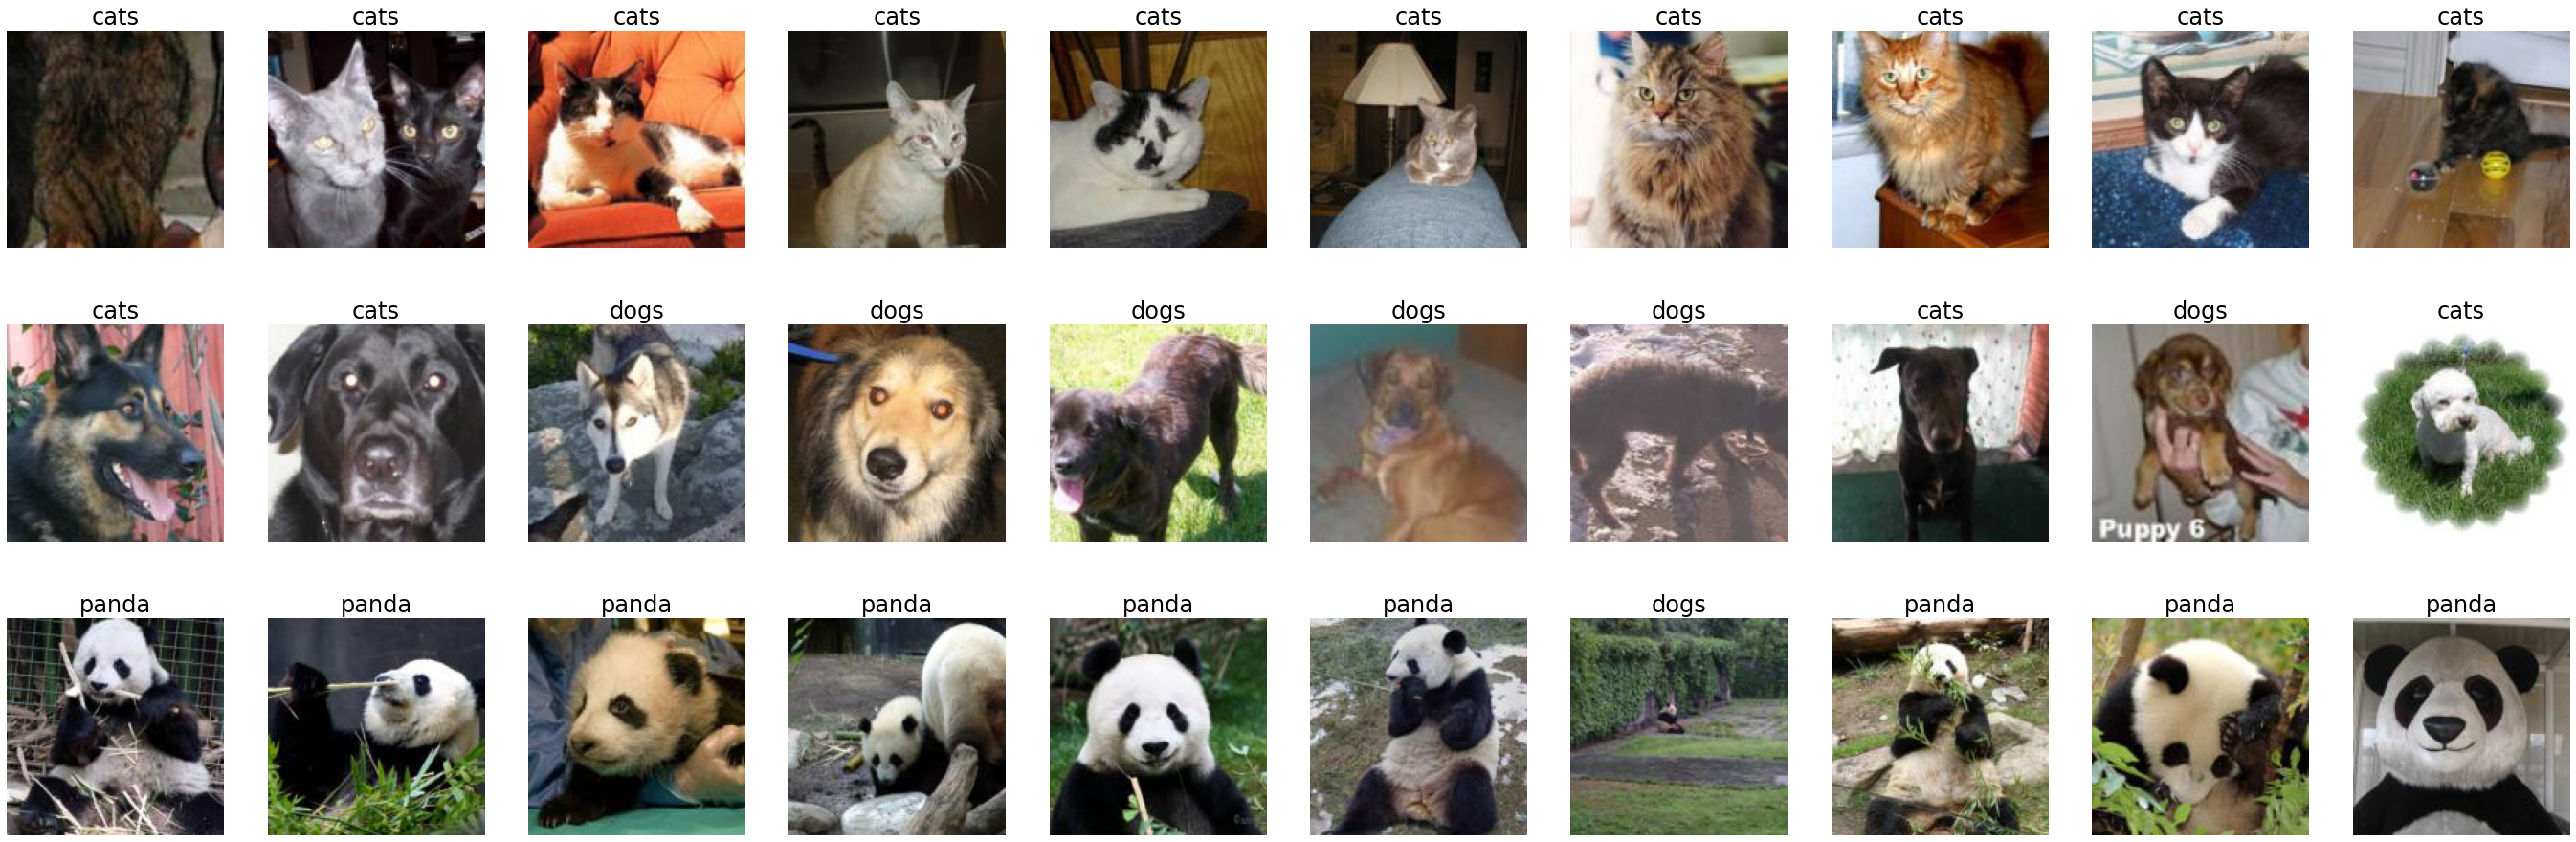

In [34]:
fig, ax = plt.subplots(3, 10, figsize = (48,16))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i, (img, cls) in enumerate(zip(img_list, prediction)):
    ax[i//10][i%10].set_title(train_dataset.categorys[cls], fontsize = 24)
    ax[i//10][i%10].imshow(np.array(img))
    ax[i//10][i%10].axis("off")
plt.show()